# Group Details

## Group Name: 12

### Student 1: Denise La Gordt Dillie

### Student 2: Andreea Maican

### Student 3: Sambhav Jain

# Loading Data and Preliminaries

In [760]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os
import math
import random
import time
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

In [761]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [762]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_array('/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(initial_state)
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
[[ 4.54673709 -5.27118739  5.07863417 -1.09690628 -3.66929964]
 [ 3.57509525  4.3270607  -0.08095022 -0.57868726 -2.95971243]
 [ 2.67733735 -5.15972108  5.35238208  2.42652043  1.45870728]
 [ 2.27455417 -6.79584511  2.29632123  0.30418238 -0.4065998 ]
 [ 2.38359341 -2.75861066  1.77940931 -0.07643627 -0.35954359]
 [ 4.28596268  0.34981219  4.8286224   1.35630962 -2.55760522]
 [ 3.03118516 -0.50562258 15.04631712 -0.94772523 14.98127867]
 [ 4.13530017  1.81342682  3.84375499 -0.6989711  -2.25092411]]
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [763]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time. 
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [764]:
test_initial_state

array([[ 4.31455329, -4.99311363, -5.10150489,  2.2491171 , -1.82520359],
       [ 2.58525749, -4.92574075, -4.7534334 , -4.81897728, -3.07212095],
       [ 2.40449047,  2.23254187, -6.04595524, -0.67381217, -0.58798851],
       [ 2.28318603,  5.6605113 , -3.76376281, -0.41268251, -1.19812499],
       [ 4.09793595, -4.73678906, -3.94704856,  1.13634781,  4.98383634],
       [ 4.5579536 , -0.08848969,  5.42483477,  1.460317  , -0.21585929],
       [ 3.42356878, -4.91282501, -4.6779343 ,  0.94123905,  2.66425652],
       [ 3.59288181, -4.48225046, -4.548729  , -2.56573061, -2.39203918]])

# Task 1

# Data Handling and Preprocessing

In [765]:
def create_graph_data_task1(initial_state, terminal_state):
    initial_state = np.array(initial_state)
    terminal_state = np.array(terminal_state)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Calculate center of mass
    total_mass = np.sum(initial_state[:, 0])
    center_of_mass_x = np.sum(initial_state[:, 1] * initial_state[:, 0]) / total_mass
    center_of_mass_y = np.sum(initial_state[:, 2] * initial_state[:, 0]) / total_mass

    # Adjust positions relative to center of mass for initial and terminal states
    initial_state[:, 1] -= center_of_mass_x
    initial_state[:, 2] -= center_of_mass_y
    
    terminal_state[:, 0] -= center_of_mass_x
    terminal_state[:, 1] -= center_of_mass_y
    
    # Find the indices of the two most massive objects
    mass_indices = np.argsort(initial_state[:, 0])
    indices = mass_indices[-2:]
    
    # Calculate the vector between the two most massive objects
    vector = initial_state[indices[1], 1:3] - initial_state[indices[0], 1:3]
    
    # Calculate the angle of rotation based on the vector
    angle = math.atan2(vector[1], vector[0])
    
    # Apply rotation to the positions
    rot_matrix = np.array([[math.cos(-angle), -math.sin(-angle)], [math.sin(-angle), math.cos(-angle)]])
    initial_state[:, 1:3] = np.matmul(rot_matrix, initial_state[:, 1:3].T).T
    terminal_state = np.matmul(rot_matrix, terminal_state.T).T
    
    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i<j)], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx**2 + dy**2)
        force = ((node_features[i,0]*node_features[j,0])/(distance**2 + 1e-8))
        edge_features[k] = force

    # Create target tensor
    target = torch.tensor(terminal_state, dtype=torch.float).view(-1, 2)  # Reshape to (num_nodes, num_features + 1)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
terminal_state = [[0.3, 0.2], [0.4, 0.6], [0.8, 0.9]]

graph_data = create_graph_data_task1(initial_state, terminal_state)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[ 1.0000, -0.2252,  0.0762,  0.2000,  0.1000],
        [ 2.0000,  0.1871,  0.0762,  0.3000,  0.2000],
        [ 0.5000, -0.2980, -0.4574,  0.9000,  1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[-0.0554,  0.2217],
        [-0.0554, -0.1906],
        [-0.3707, -0.5786]])


In [766]:
def create_dataloader_task1(data_folder, task, shuffle, batch_size, train_ratio=0.8):
    data_list = []  # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, terminal_state = states

        # Create the Data object using create_graph_data function
        data = create_graph_data_task1(initial_state, terminal_state)

        # Append the Data object to the list
        data_list.append(data)

    # Shuffle the data if specified
    if shuffle:
        random.shuffle(data_list)

    # Calculate the number of samples
    num_samples = len(data_list)

    if "train" in data_folder:
        # Calculate the number of samples for train and validation
        num_train = int(train_ratio * num_samples)
        num_val = num_samples - num_train

        # Split the data into train and validation sets
        train_data = data_list[:num_train]
        val_data = data_list[num_train:]

        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")
        print(f"Number of training samples: {num_train}")
        print(f"Number of validation samples: {num_val}")

        # Create data loaders for train and validation sets
        dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        return dataloader_train, dataloader_val, data_list
    else:
        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")

        # Create a data loader for the data
        dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

        return dataloader, data_list

# Specify the paths to your train and test data folders
data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train'
data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader_task1(data_folder_train, task='task 1', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader_task1(data_folder_test, task='task 1', shuffle=False, batch_size=batch_size)

Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 1/test: 100


# Model Implementation

In [767]:
from torch_geometric.nn import SAGEConv

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()

        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.conv4 = SAGEConv(256, 512)
        self.conv5 = SAGEConv(512, 256)
        self.conv6 = SAGEConv(256, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = self.conv6(x, edge_index)

        return x

# Model Training

In [768]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [769]:
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = torch.nn.MSELoss()

def train(loader):
    model.train()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    for data in loader:
        data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()
        batch_size = true_labels.shape[0]
        total_samples += batch_size

         # R2 Score
        total_r2_score += r2_score(true_labels, predictions) * batch_size

        # MAE
        mae = mean_absolute_error(true_labels, predictions)
        total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_r2_score = 0
    total_mae = 0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            data.to(device)
            output = model(data)
            loss = loss_func(output, data.y)
            total_loss += loss.item()

            predictions = output.detach().cpu().numpy()
            true_labels = data.y.detach().cpu().numpy()
            batch_size = true_labels.shape[0]
            total_samples += batch_size

            # R2 Score
            total_r2_score += r2_score(true_labels, predictions) * batch_size

            # MAE
            mae = mean_absolute_error(true_labels, predictions)
            total_mae += mae * batch_size

    avg_loss = total_loss / len(loader)
    avg_r2_score = total_r2_score / total_samples
    avg_mae = total_mae / total_samples

    return avg_loss, avg_r2_score, avg_mae

In [770]:
epochs = 50
start = time.time()

train_losses, train_r2_scores, train_maes = [], [], []
val_losses, val_r2_scores, val_maes = [], [], []
test_losses, test_r2_scores, test_maes = [], [], []

for epoch in tqdm(range(1, epochs + 1)):

    train_loss, train_r2_score, train_mae = train(dataloader_train)
    val_loss, val_r2_score, val_mae = evaluate(dataloader_val)
    test_loss, test_r2_score, test_mae = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n'
          f'TRAIN R2: {train_r2_score:.4f}, VAL R2: {val_r2_score:.4f}, TEST R2: {test_r2_score:.4f}\n'
          f'TRAIN MAE: {train_mae:.4f}, VAL MAE: {val_mae:.4f}, TEST MAE: {test_mae:.4f}\n')

    # Store metrics
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)
    train_maes.append(train_mae)

    val_losses.append(val_loss)
    val_r2_scores.append(val_r2_score)
    val_maes.append(val_mae)

    test_losses.append(test_loss)
    test_r2_scores.append(test_r2_score)
    test_maes.append(test_mae)

  4%|▍         | 2/50 [00:00<00:09,  5.25it/s]

EPOCH: 001, TRAIN LOSS: 13.2697, VAL LOSS: 10.4117, TEST LOSS: 7.9221. TRAINING TIME SO FAR: 0.2 s
TRAIN R2: 0.3213, VAL R2: 0.4657, TEST R2: 0.5607
TRAIN MAE: 2.7977, VAL MAE: 2.4355, TEST MAE: 2.2116

EPOCH: 002, TRAIN LOSS: 8.1517, VAL LOSS: 7.8079, TEST LOSS: 5.6332. TRAINING TIME SO FAR: 0.4 s
TRAIN R2: 0.5870, VAL R2: 0.5917, TEST R2: 0.6849
TRAIN MAE: 2.1022, VAL MAE: 2.0899, TEST MAE: 1.8431



  8%|▊         | 4/50 [00:00<00:08,  5.61it/s]

EPOCH: 003, TRAIN LOSS: 7.4899, VAL LOSS: 7.8891, TEST LOSS: 5.9452. TRAINING TIME SO FAR: 0.6 s
TRAIN R2: 0.6208, VAL R2: 0.5882, TEST R2: 0.6687
TRAIN MAE: 1.9927, VAL MAE: 2.1136, TEST MAE: 1.8915

EPOCH: 004, TRAIN LOSS: 7.4100, VAL LOSS: 8.0080, TEST LOSS: 5.5926. TRAINING TIME SO FAR: 0.7 s
TRAIN R2: 0.6209, VAL R2: 0.5834, TEST R2: 0.6873
TRAIN MAE: 2.0032, VAL MAE: 2.1025, TEST MAE: 1.8253



 12%|█▏        | 6/50 [00:01<00:07,  5.75it/s]

EPOCH: 005, TRAIN LOSS: 6.9959, VAL LOSS: 7.7660, TEST LOSS: 5.4006. TRAINING TIME SO FAR: 0.9 s
TRAIN R2: 0.6425, VAL R2: 0.5937, TEST R2: 0.6975
TRAIN MAE: 1.9502, VAL MAE: 2.0373, TEST MAE: 1.7672

EPOCH: 006, TRAIN LOSS: 6.7667, VAL LOSS: 7.5387, TEST LOSS: 5.1994. TRAINING TIME SO FAR: 1.1 s
TRAIN R2: 0.6486, VAL R2: 0.6044, TEST R2: 0.7104
TRAIN MAE: 1.9308, VAL MAE: 2.0232, TEST MAE: 1.7547



 16%|█▌        | 8/50 [00:01<00:07,  5.84it/s]

EPOCH: 007, TRAIN LOSS: 6.5471, VAL LOSS: 7.5849, TEST LOSS: 5.1815. TRAINING TIME SO FAR: 1.2 s
TRAIN R2: 0.6574, VAL R2: 0.6069, TEST R2: 0.7107
TRAIN MAE: 1.9080, VAL MAE: 2.0319, TEST MAE: 1.7577

EPOCH: 008, TRAIN LOSS: 6.8545, VAL LOSS: 7.5366, TEST LOSS: 5.3043. TRAINING TIME SO FAR: 1.4 s
TRAIN R2: 0.6564, VAL R2: 0.6076, TEST R2: 0.7042
TRAIN MAE: 1.8811, VAL MAE: 2.0470, TEST MAE: 1.7790



 20%|██        | 10/50 [00:01<00:06,  5.89it/s]

EPOCH: 009, TRAIN LOSS: 6.5583, VAL LOSS: 7.6018, TEST LOSS: 5.2020. TRAINING TIME SO FAR: 1.6 s
TRAIN R2: 0.6645, VAL R2: 0.6042, TEST R2: 0.7098
TRAIN MAE: 1.8699, VAL MAE: 2.0407, TEST MAE: 1.7535

EPOCH: 010, TRAIN LOSS: 6.4560, VAL LOSS: 7.5641, TEST LOSS: 5.2265. TRAINING TIME SO FAR: 1.7 s
TRAIN R2: 0.6693, VAL R2: 0.6047, TEST R2: 0.7086
TRAIN MAE: 1.8758, VAL MAE: 2.0402, TEST MAE: 1.7612



 24%|██▍       | 12/50 [00:02<00:06,  5.67it/s]

EPOCH: 011, TRAIN LOSS: 6.1186, VAL LOSS: 7.3816, TEST LOSS: 5.0379. TRAINING TIME SO FAR: 1.9 s
TRAIN R2: 0.6820, VAL R2: 0.6149, TEST R2: 0.7192
TRAIN MAE: 1.8379, VAL MAE: 2.0040, TEST MAE: 1.7143

EPOCH: 012, TRAIN LOSS: 5.9667, VAL LOSS: 7.5480, TEST LOSS: 5.1608. TRAINING TIME SO FAR: 2.1 s
TRAIN R2: 0.6865, VAL R2: 0.6067, TEST R2: 0.7133
TRAIN MAE: 1.8272, VAL MAE: 2.0294, TEST MAE: 1.7436



 28%|██▊       | 14/50 [00:02<00:06,  5.76it/s]

EPOCH: 013, TRAIN LOSS: 6.2404, VAL LOSS: 7.6438, TEST LOSS: 5.4651. TRAINING TIME SO FAR: 2.3 s
TRAIN R2: 0.6868, VAL R2: 0.5996, TEST R2: 0.6941
TRAIN MAE: 1.7991, VAL MAE: 2.0564, TEST MAE: 1.8036

EPOCH: 014, TRAIN LOSS: 5.8482, VAL LOSS: 7.4414, TEST LOSS: 5.0795. TRAINING TIME SO FAR: 2.5 s
TRAIN R2: 0.6962, VAL R2: 0.6099, TEST R2: 0.7172
TRAIN MAE: 1.7961, VAL MAE: 2.0187, TEST MAE: 1.7338



 32%|███▏      | 16/50 [00:02<00:05,  5.83it/s]

EPOCH: 015, TRAIN LOSS: 5.7189, VAL LOSS: 7.4925, TEST LOSS: 5.0609. TRAINING TIME SO FAR: 2.6 s
TRAIN R2: 0.7029, VAL R2: 0.6101, TEST R2: 0.7183
TRAIN MAE: 1.7706, VAL MAE: 2.0243, TEST MAE: 1.7256

EPOCH: 016, TRAIN LOSS: 5.8630, VAL LOSS: 7.9305, TEST LOSS: 5.4566. TRAINING TIME SO FAR: 2.8 s
TRAIN R2: 0.7024, VAL R2: 0.5853, TEST R2: 0.6945
TRAIN MAE: 1.7755, VAL MAE: 2.0901, TEST MAE: 1.7879



 36%|███▌      | 18/50 [00:03<00:05,  5.85it/s]

EPOCH: 017, TRAIN LOSS: 5.6074, VAL LOSS: 7.8608, TEST LOSS: 5.3177. TRAINING TIME SO FAR: 3.0 s
TRAIN R2: 0.7086, VAL R2: 0.5895, TEST R2: 0.7024
TRAIN MAE: 1.7696, VAL MAE: 2.0867, TEST MAE: 1.7699

EPOCH: 018, TRAIN LOSS: 5.3909, VAL LOSS: 7.5918, TEST LOSS: 5.2994. TRAINING TIME SO FAR: 3.1 s
TRAIN R2: 0.7185, VAL R2: 0.6041, TEST R2: 0.7050
TRAIN MAE: 1.7354, VAL MAE: 2.0411, TEST MAE: 1.7611



 40%|████      | 20/50 [00:03<00:05,  5.88it/s]

EPOCH: 019, TRAIN LOSS: 5.3339, VAL LOSS: 8.0911, TEST LOSS: 5.5358. TRAINING TIME SO FAR: 3.3 s
TRAIN R2: 0.7270, VAL R2: 0.5814, TEST R2: 0.6921
TRAIN MAE: 1.7062, VAL MAE: 2.1114, TEST MAE: 1.8156

EPOCH: 020, TRAIN LOSS: 5.1236, VAL LOSS: 7.5020, TEST LOSS: 5.0346. TRAINING TIME SO FAR: 3.5 s
TRAIN R2: 0.7315, VAL R2: 0.6100, TEST R2: 0.7200
TRAIN MAE: 1.7024, VAL MAE: 2.0315, TEST MAE: 1.7370



 44%|████▍     | 22/50 [00:03<00:04,  5.89it/s]

EPOCH: 021, TRAIN LOSS: 4.9105, VAL LOSS: 7.8827, TEST LOSS: 5.2662. TRAINING TIME SO FAR: 3.6 s
TRAIN R2: 0.7424, VAL R2: 0.5907, TEST R2: 0.7074
TRAIN MAE: 1.6618, VAL MAE: 2.0859, TEST MAE: 1.7392

EPOCH: 022, TRAIN LOSS: 4.7848, VAL LOSS: 7.8232, TEST LOSS: 5.3714. TRAINING TIME SO FAR: 3.8 s
TRAIN R2: 0.7518, VAL R2: 0.5909, TEST R2: 0.7029
TRAIN MAE: 1.6317, VAL MAE: 2.0957, TEST MAE: 1.7687



 48%|████▊     | 24/50 [00:04<00:04,  5.77it/s]

EPOCH: 023, TRAIN LOSS: 4.8255, VAL LOSS: 7.9665, TEST LOSS: 5.3650. TRAINING TIME SO FAR: 4.0 s
TRAIN R2: 0.7515, VAL R2: 0.5861, TEST R2: 0.7006
TRAIN MAE: 1.6371, VAL MAE: 2.0922, TEST MAE: 1.7692

EPOCH: 024, TRAIN LOSS: 4.5839, VAL LOSS: 7.8371, TEST LOSS: 5.6131. TRAINING TIME SO FAR: 4.2 s
TRAIN R2: 0.7619, VAL R2: 0.5922, TEST R2: 0.6879
TRAIN MAE: 1.6082, VAL MAE: 2.0905, TEST MAE: 1.8132



 52%|█████▏    | 26/50 [00:04<00:04,  5.57it/s]

EPOCH: 025, TRAIN LOSS: 4.5117, VAL LOSS: 8.1916, TEST LOSS: 5.9628. TRAINING TIME SO FAR: 4.4 s
TRAIN R2: 0.7690, VAL R2: 0.5728, TEST R2: 0.6661
TRAIN MAE: 1.5634, VAL MAE: 2.1415, TEST MAE: 1.8693

EPOCH: 026, TRAIN LOSS: 4.7346, VAL LOSS: 8.2796, TEST LOSS: 5.8308. TRAINING TIME SO FAR: 4.5 s
TRAIN R2: 0.7564, VAL R2: 0.5664, TEST R2: 0.6746
TRAIN MAE: 1.6167, VAL MAE: 2.1506, TEST MAE: 1.8539



 56%|█████▌    | 28/50 [00:04<00:03,  5.73it/s]

EPOCH: 027, TRAIN LOSS: 6.2781, VAL LOSS: 8.6215, TEST LOSS: 6.0306. TRAINING TIME SO FAR: 4.7 s
TRAIN R2: 0.7441, VAL R2: 0.5522, TEST R2: 0.6611
TRAIN MAE: 1.6300, VAL MAE: 2.1995, TEST MAE: 1.8892

EPOCH: 028, TRAIN LOSS: 5.1292, VAL LOSS: 7.9949, TEST LOSS: 5.7197. TRAINING TIME SO FAR: 4.9 s
TRAIN R2: 0.7357, VAL R2: 0.5826, TEST R2: 0.6822
TRAIN MAE: 1.6921, VAL MAE: 2.1247, TEST MAE: 1.8406



 60%|██████    | 30/50 [00:05<00:03,  5.83it/s]

EPOCH: 029, TRAIN LOSS: 4.3891, VAL LOSS: 8.4020, TEST LOSS: 5.5669. TRAINING TIME SO FAR: 5.1 s
TRAIN R2: 0.7707, VAL R2: 0.5641, TEST R2: 0.6894
TRAIN MAE: 1.5751, VAL MAE: 2.1607, TEST MAE: 1.8063

EPOCH: 030, TRAIN LOSS: 3.9443, VAL LOSS: 8.3411, TEST LOSS: 5.9080. TRAINING TIME SO FAR: 5.2 s
TRAIN R2: 0.7931, VAL R2: 0.5657, TEST R2: 0.6702
TRAIN MAE: 1.4897, VAL MAE: 2.1734, TEST MAE: 1.8524



 64%|██████▍   | 32/50 [00:05<00:03,  5.86it/s]

EPOCH: 031, TRAIN LOSS: 3.9938, VAL LOSS: 8.4500, TEST LOSS: 5.7165. TRAINING TIME SO FAR: 5.4 s
TRAIN R2: 0.7937, VAL R2: 0.5624, TEST R2: 0.6809
TRAIN MAE: 1.4853, VAL MAE: 2.1628, TEST MAE: 1.8228

EPOCH: 032, TRAIN LOSS: 3.7855, VAL LOSS: 8.1474, TEST LOSS: 5.6833. TRAINING TIME SO FAR: 5.6 s
TRAIN R2: 0.8037, VAL R2: 0.5764, TEST R2: 0.6823
TRAIN MAE: 1.4484, VAL MAE: 2.1474, TEST MAE: 1.8220



 68%|██████▊   | 34/50 [00:05<00:02,  5.92it/s]

EPOCH: 033, TRAIN LOSS: 3.4944, VAL LOSS: 8.2926, TEST LOSS: 5.7947. TRAINING TIME SO FAR: 5.7 s
TRAIN R2: 0.8170, VAL R2: 0.5695, TEST R2: 0.6764
TRAIN MAE: 1.4009, VAL MAE: 2.1548, TEST MAE: 1.8438

EPOCH: 034, TRAIN LOSS: 3.3746, VAL LOSS: 8.9708, TEST LOSS: 6.1076. TRAINING TIME SO FAR: 5.9 s
TRAIN R2: 0.8289, VAL R2: 0.5338, TEST R2: 0.6576
TRAIN MAE: 1.3570, VAL MAE: 2.2566, TEST MAE: 1.9020



 72%|███████▏  | 36/50 [00:06<00:02,  5.84it/s]

EPOCH: 035, TRAIN LOSS: 3.2619, VAL LOSS: 8.5577, TEST LOSS: 6.1149. TRAINING TIME SO FAR: 6.1 s
TRAIN R2: 0.8331, VAL R2: 0.5549, TEST R2: 0.6560
TRAIN MAE: 1.3325, VAL MAE: 2.1917, TEST MAE: 1.8925

EPOCH: 036, TRAIN LOSS: 2.8790, VAL LOSS: 8.6475, TEST LOSS: 5.9934. TRAINING TIME SO FAR: 6.2 s
TRAIN R2: 0.8499, VAL R2: 0.5529, TEST R2: 0.6630
TRAIN MAE: 1.2737, VAL MAE: 2.2039, TEST MAE: 1.8697



 76%|███████▌  | 38/50 [00:06<00:02,  5.69it/s]

EPOCH: 037, TRAIN LOSS: 2.9663, VAL LOSS: 9.1214, TEST LOSS: 6.3332. TRAINING TIME SO FAR: 6.4 s
TRAIN R2: 0.8469, VAL R2: 0.5269, TEST R2: 0.6436
TRAIN MAE: 1.3015, VAL MAE: 2.2788, TEST MAE: 1.9395

EPOCH: 038, TRAIN LOSS: 2.8995, VAL LOSS: 8.8875, TEST LOSS: 6.0027. TRAINING TIME SO FAR: 6.6 s
TRAIN R2: 0.8496, VAL R2: 0.5368, TEST R2: 0.6631
TRAIN MAE: 1.2824, VAL MAE: 2.2432, TEST MAE: 1.8713



 80%|████████  | 40/50 [00:06<00:01,  5.80it/s]

EPOCH: 039, TRAIN LOSS: 2.6821, VAL LOSS: 9.0849, TEST LOSS: 6.3651. TRAINING TIME SO FAR: 6.8 s
TRAIN R2: 0.8609, VAL R2: 0.5297, TEST R2: 0.6419
TRAIN MAE: 1.2227, VAL MAE: 2.2606, TEST MAE: 1.9312

EPOCH: 040, TRAIN LOSS: 2.5381, VAL LOSS: 8.8108, TEST LOSS: 6.2600. TRAINING TIME SO FAR: 6.9 s
TRAIN R2: 0.8674, VAL R2: 0.5426, TEST R2: 0.6484
TRAIN MAE: 1.1937, VAL MAE: 2.2502, TEST MAE: 1.9035



 84%|████████▍ | 42/50 [00:07<00:01,  5.88it/s]

EPOCH: 041, TRAIN LOSS: 2.7080, VAL LOSS: 10.1500, TEST LOSS: 7.2110. TRAINING TIME SO FAR: 7.1 s
TRAIN R2: 0.8736, VAL R2: 0.4728, TEST R2: 0.5914
TRAIN MAE: 1.1585, VAL MAE: 2.3939, TEST MAE: 2.0565

EPOCH: 042, TRAIN LOSS: 4.5461, VAL LOSS: 9.7119, TEST LOSS: 7.1180. TRAINING TIME SO FAR: 7.3 s
TRAIN R2: 0.7823, VAL R2: 0.4928, TEST R2: 0.5973
TRAIN MAE: 1.4597, VAL MAE: 2.3707, TEST MAE: 2.0670



 88%|████████▊ | 44/50 [00:07<00:01,  5.91it/s]

EPOCH: 043, TRAIN LOSS: 5.6646, VAL LOSS: 8.6528, TEST LOSS: 6.1563. TRAINING TIME SO FAR: 7.4 s
TRAIN R2: 0.7218, VAL R2: 0.5477, TEST R2: 0.6545
TRAIN MAE: 1.6832, VAL MAE: 2.2126, TEST MAE: 1.8933

EPOCH: 044, TRAIN LOSS: 4.2369, VAL LOSS: 8.8504, TEST LOSS: 6.4010. TRAINING TIME SO FAR: 7.6 s
TRAIN R2: 0.7936, VAL R2: 0.5386, TEST R2: 0.6423
TRAIN MAE: 1.4498, VAL MAE: 2.2450, TEST MAE: 1.9546



 92%|█████████▏| 46/50 [00:07<00:00,  5.95it/s]

EPOCH: 045, TRAIN LOSS: 3.4661, VAL LOSS: 8.6191, TEST LOSS: 6.0179. TRAINING TIME SO FAR: 7.8 s
TRAIN R2: 0.8261, VAL R2: 0.5509, TEST R2: 0.6604
TRAIN MAE: 1.3418, VAL MAE: 2.2050, TEST MAE: 1.8819

EPOCH: 046, TRAIN LOSS: 2.8650, VAL LOSS: 9.0316, TEST LOSS: 6.3535. TRAINING TIME SO FAR: 7.9 s
TRAIN R2: 0.8541, VAL R2: 0.5274, TEST R2: 0.6428
TRAIN MAE: 1.2480, VAL MAE: 2.2756, TEST MAE: 1.9260



 96%|█████████▌| 48/50 [00:08<00:00,  5.92it/s]

EPOCH: 047, TRAIN LOSS: 3.0398, VAL LOSS: 8.7653, TEST LOSS: 5.9624. TRAINING TIME SO FAR: 8.1 s
TRAIN R2: 0.8492, VAL R2: 0.5432, TEST R2: 0.6644
TRAIN MAE: 1.2611, VAL MAE: 2.2126, TEST MAE: 1.8565

EPOCH: 048, TRAIN LOSS: 3.2781, VAL LOSS: 8.8409, TEST LOSS: 6.4728. TRAINING TIME SO FAR: 8.3 s
TRAIN R2: 0.8426, VAL R2: 0.5382, TEST R2: 0.6356
TRAIN MAE: 1.2538, VAL MAE: 2.2390, TEST MAE: 1.9264



100%|██████████| 50/50 [00:08<00:00,  5.79it/s]

EPOCH: 049, TRAIN LOSS: 2.6854, VAL LOSS: 9.1716, TEST LOSS: 6.5105. TRAINING TIME SO FAR: 8.5 s
TRAIN R2: 0.8727, VAL R2: 0.5212, TEST R2: 0.6334
TRAIN MAE: 1.1416, VAL MAE: 2.2652, TEST MAE: 1.9311

EPOCH: 050, TRAIN LOSS: 2.1559, VAL LOSS: 8.9680, TEST LOSS: 6.5251. TRAINING TIME SO FAR: 8.6 s
TRAIN R2: 0.8911, VAL R2: 0.5315, TEST R2: 0.6324
TRAIN MAE: 1.0735, VAL MAE: 2.2643, TEST MAE: 1.9414



# Evaluation

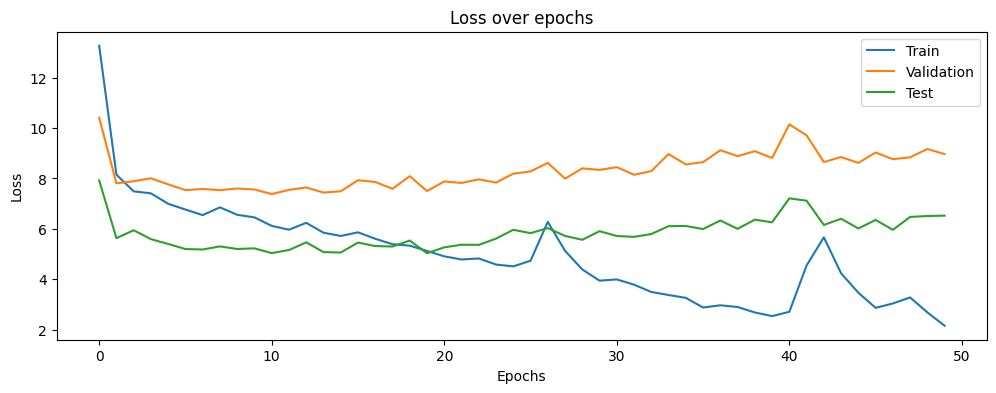

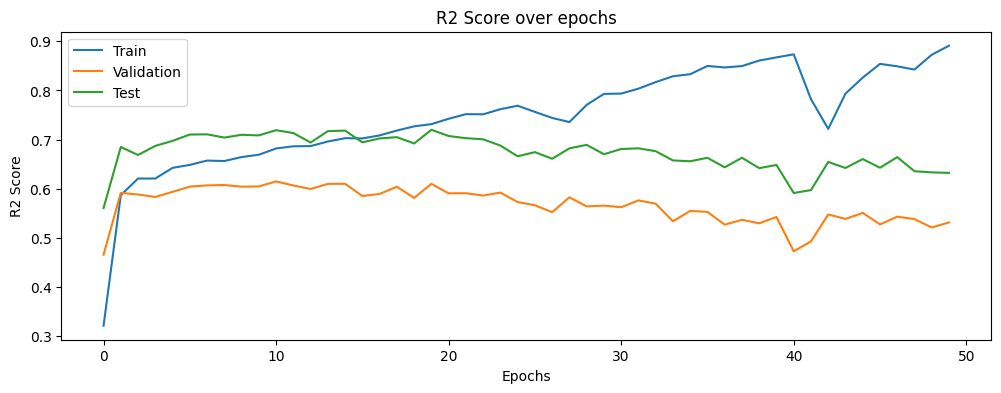

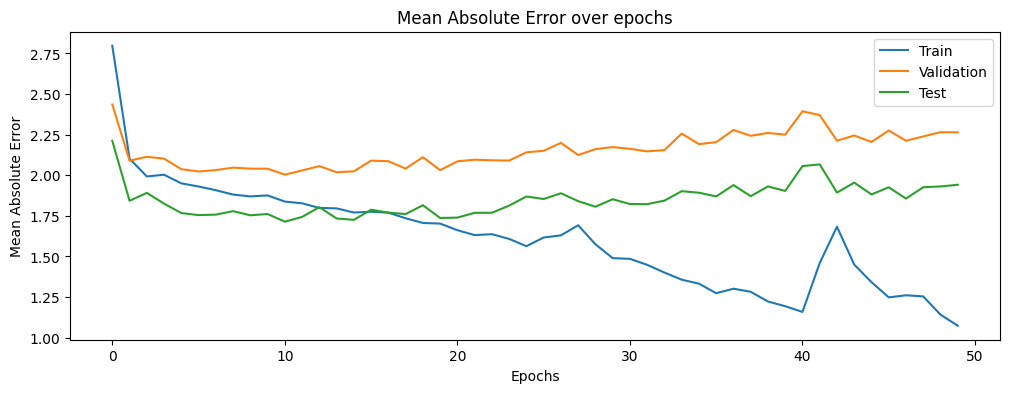

In [771]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot R2 scores
plt.figure(figsize=(12, 4))
plt.plot(train_r2_scores, label='Train')
plt.plot(val_r2_scores, label='Validation')
plt.plot(test_r2_scores, label='Test')
plt.title('R2 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

# Plot MAEs
plt.figure(figsize=(12, 4))
plt.plot(train_maes, label='Train')
plt.plot(val_maes, label='Validation')
plt.plot(test_maes, label='Test')
plt.title('Mean Absolute Error over epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [774]:
def test_example(idx):
    example = data_list_test[idx]
    print(f'Number of objects = {example.x.shape[0]}')
    pred = model(example)
    true = example.y
    print(f'Predicted = \n {pred},\n Ground-truth = \n {true}')

test_example(69)

Number of objects = 4
Predicted = 
 tensor([[-3.8415, -2.8606],
        [-0.1509,  3.6389],
        [ 3.8629,  0.5163],
        [-2.4974,  0.9261]], grad_fn=<AddBackward0>),
 Ground-truth = 
 tensor([[-6.2194, -1.7776],
        [-0.7291,  1.7628],
        [ 5.8773, -0.7688],
        [-0.7455,  1.1968]])


49
15
Best Prediction:
Predicted: tensor([[-4.2029,  1.5404],
        [-0.7845, -1.7979],
        [-3.8487,  3.1269],
        [ 7.7387, -1.0013],
        [ 5.1025, -3.4620]], grad_fn=<AddBackward0>)
Ground Truth: tensor([[-3.6062,  2.0311],
        [-2.1979, -0.7593],
        [-3.8360,  2.8207],
        [ 8.2181, -1.4074],
        [ 3.3610, -2.8819]])

Worst Prediction:
Predicted: tensor([[ 0.1923,  4.4787],
        [-3.5519,  5.1616],
        [-4.0275,  1.5179],
        [ 2.7162, -3.1433],
        [ 3.7148, -4.8719],
        [ 3.3522, -5.2112],
        [-2.3400,  2.1881]], grad_fn=<AddBackward0>)
Ground Truth: tensor([[-11.4410,  -3.9949],
        [ -2.0440,   2.3187],
        [ -1.0526,   1.2658],
        [  3.2806,  -0.1443],
        [  2.3582,  -2.4777],
        [  3.8380,  -1.1217],
        [ -2.1108,   2.5135]])



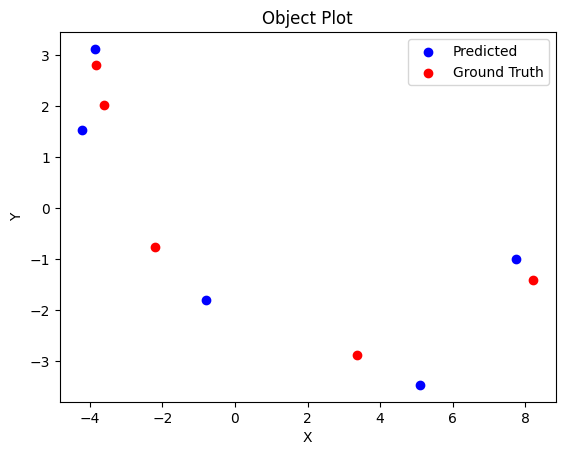

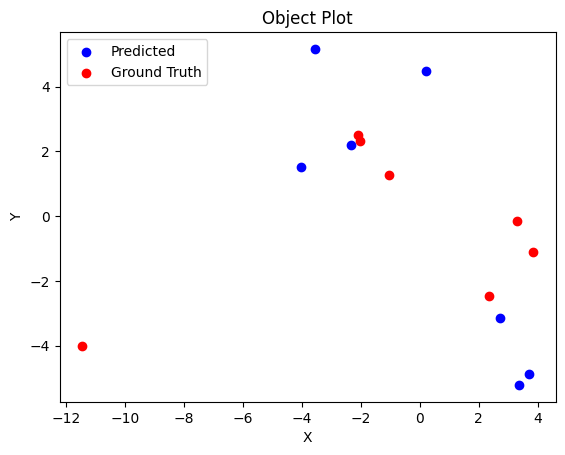

In [773]:
import torch
import matplotlib.pyplot as plt

def test_example(idx):
    example = data_list_test[idx]
    print(f'Number of objects = {example.x.shape[0]}')
    pred = model(example)
    true = example.y
    print(f'Predicted = \n {pred},\n Ground-truth = \n {true}')
    plot_objects(pred, true)

def plot_objects(pred, true):
    plt.scatter(pred[:, 0].detach().numpy(), pred[:, 1].detach().numpy(), c='blue', label='Predicted')
    plt.scatter(true[:, 0].detach().numpy(), true[:, 1].detach().numpy(), c='red', label='Ground Truth')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Object Plot')
    plt.legend()
    plt.show()

def find_best_worst_predictions(predictions, ground_truth):
    distances = torch.norm(predictions - ground_truth, dim=1)
    best_idx = torch.argmin(distances)
    worst_idx = torch.argmax(distances)
    return best_idx.item(), worst_idx.item()

# Assuming 'model' is the trained model
# Assuming 'data_list_test' is the test dataset

best_idx = None
worst_idx = None
best_distance = float('inf')
worst_distance = float('-inf')

# Iterate through the test set to find the best and worst predictions
for idx, example in enumerate(data_list_test):
    pred = model(example)
    true = example.y
    distance = torch.norm(pred - true)
    if distance < best_distance:
        best_distance = distance
        best_idx = idx
    if distance > worst_distance:
        worst_distance = distance
        worst_idx = idx

best_prediction = model(data_list_test[best_idx])
best_ground_truth = data_list_test[best_idx].y

print(best_idx)
print(worst_idx)

worst_prediction = model(data_list_test[worst_idx])
worst_ground_truth = data_list_test[worst_idx].y

print("Best Prediction:")
print("Predicted:", best_prediction)
print("Ground Truth:", best_ground_truth)
print()

print("Worst Prediction:")
print("Predicted:", worst_prediction)
print("Ground Truth:", worst_ground_truth)
print()

plot_objects(best_prediction, best_ground_truth)
plot_objects(worst_prediction, worst_ground_truth)

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

def test_example(idx):
    example = data_list_test[idx]
    print(f'Number of objects = {example.x.shape[0]}')
    pred = model(example)
    true = example.y
    print(f'Predicted = \n {pred},\n Ground-truth = \n {true}')
    plot_objects(pred, true)

def plot_objects(pred, true):
    plt.scatter(pred[:, 0].detach().numpy(), pred[:, 1].detach().numpy(), c='blue', label='Predicted')
    plt.scatter(true[:, 0].detach().numpy(), true[:, 1].detach().numpy(), c='red', label='Ground Truth')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Object Plot')
    plt.legend()
    plt.show()

def find_best_worst_predictions(predictions, ground_truth):
    distances = torch.norm(predictions - ground_truth, dim=1)
    best_idx = torch.argmin(distances)
    worst_idx = torch.argmax(distances)
    return best_idx.item(), worst_idx.item()

# Assuming 'model' is the trained model
# Assuming 'data_list_test' is the test dataset

best_idx = None
worst_idx = None
best_distance = float('inf')
worst_distance = float('-inf')

# Iterate through the test set to find the best and worst predictions
for idx, example in enumerate(data_list_test):
    pred = model(example)
    true = example.y
    distance = torch.norm(pred - true)
    if distance < best_distance:
        best_distance = distance
        best_idx = idx
    if distance > worst_distance:
        worst_distance = distance
        worst_idx = idx


print(best_idx)
print(worst_idx)

best_prediction = model(data_list_test[best_idx])
best_ground_truth = data_list_test[best_idx].y

worst_prediction = model(data_list_test[worst_idx])
worst_ground_truth = data_list_test[worst_idx].y

best_table = pd.DataFrame({
    'Coordinate X': best_ground_truth[:, 0].tolist(),
    'Coordinate Y': best_ground_truth[:, 1].tolist(),
    'Distance': [best_distance.item()] * best_ground_truth.shape[0]
})

worst_table = pd.DataFrame({
    'Coordinate X': worst_ground_truth[:, 0].tolist(),
    'Coordinate Y': worst_ground_truth[:, 1].tolist(),
    'Distance': [worst_distance.item()] * worst_ground_truth.shape[0]
})

print("Best Case:")
print(best_table)
print()

print("Worst Case:")
print(worst_table)
print()

plot_objects(best_prediction, best_ground_truth)
plot_objects(worst_prediction, worst_ground_truth)

# Task 2

# Data Handling and Preprocessing


In [752]:
def create_graph_data_task2(initial_state, trajectory):
    initial_state = np.array(initial_state)
    trajectory = np.array(trajectory)

    n_bodies = initial_state.shape[0]
    num_features = initial_state.shape[1]

    # Calculate center of mass
    total_mass = np.sum(initial_state[:, 0])
    center_of_mass_x = np.sum(initial_state[:, 1] * initial_state[:, 0]) / total_mass
    center_of_mass_y = np.sum(initial_state[:, 2] * initial_state[:, 0]) / total_mass

    # Adjust positions relative to center of mass for initial and terminal states
    initial_state[:, 1] -= center_of_mass_x
    initial_state[:, 2] -= center_of_mass_y

    trajectory[:, :, 0] -= center_of_mass_x
    trajectory[:, :, 1] -= center_of_mass_y

    # Find the indices of the two most massive objects
    mass_indices = np.argsort(initial_state[:, 0])
    indices = mass_indices[-2:]

    # Calculate the vector between the two most massive objects
    vector = initial_state[indices[1], 1:3] - initial_state[indices[0], 1:3]

    # Calculate the angle of rotation based on the vector
    angle = math.atan2(vector[1], vector[0])

    # Apply rotation to the positions
    rot_matrix = np.array([[math.cos(-angle), -math.sin(-angle)], [math.sin(-angle), math.cos(-angle)]])
    initial_state[:, 1:3] = np.matmul(rot_matrix, initial_state[:, 1:3].T).T
    for i in range(trajectory.shape[1]):
        trajectory[:, i, :2] = np.matmul(rot_matrix, trajectory[:, i, :2].T).T

    # Create node features tensor
    node_features = torch.tensor(initial_state, dtype=torch.float)
    node_features = node_features.view(-1, num_features)  # Reshape to (num_nodes, num_features)

    # Check the number of nodes
    assert n_bodies == initial_state.shape[0], "Mismatch between n_bodies and actual number of nodes"

    # Create edge index tensor
    edge_index = torch.tensor([[i, j] for i in range(n_bodies) for j in range(n_bodies) if (i != j and i<j)], dtype=torch.long)
    edge_index = edge_index.t().contiguous()  # Reshape to (2, num_edges)

    # Create edge features tensor
    num_edges = edge_index.size(1)
    edge_features = torch.empty(num_edges, 1, dtype=torch.float)
    # Populate edge features with force
    for k, (i, j) in enumerate(edge_index.t()):
        dx = node_features[i, 1] - node_features[j, 1]
        dy = node_features[i, 2] - node_features[j, 2]
        distance = torch.sqrt(dx**2 + dy**2)
        force = ((node_features[i,0]*node_features[j,0])/(distance**2 + 1e-8))
        edge_features[k] = force

    # # Create target tensor
    # if trajectory.shape[2] == 2:  # If only positions are used
    #     target = torch.tensor(trajectory, dtype=torch.float).reshape(n_bodies, -1, 2)
    # else:  # If both positions and velocities are used
    #     target = torch.tensor(trajectory, dtype=torch.float).reshape(n_bodies, -1, 4)

     # Create target tensor
    target = torch.tensor(trajectory, dtype=torch.float).reshape(n_bodies, -1, 4)

    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=target)

    return data

# Example usage
initial_state = [[1.0, 0.5, 0.3, 0.2, 0.1], [2.0, 0.1, 0.4, 0.3, 0.2], [0.5, 0.7, 0.8, 0.9, 1.0]]
trajectory = [
    [[0.3, 0.2], [0.4, 0.3], [0.5, 0.4], [0.6, 0.5]],
    [[0.4, 0.6], [0.5, 0.7], [0.6, 0.8], [0.7, 0.9]],
    [[0.8, 0.9], [0.9, 1.0], [1.0, 1.1], [1.1, 1.2]]
]

graph_data = create_graph_data_task2(initial_state, trajectory)
print(graph_data.x, graph_data.edge_index, graph_data.edge_attr, graph_data.y)

tensor([[ 1.0000, -0.2252,  0.0762,  0.2000,  0.1000],
        [ 2.0000,  0.1871,  0.0762,  0.3000,  0.2000],
        [ 0.5000, -0.2980, -0.4574,  0.9000,  1.0000]]) tensor([[0, 0, 1],
        [1, 2, 2]]) tensor([[11.7647],
        [ 1.7241],
        [ 1.9231]]) tensor([[[-0.0554,  0.2217, -0.1282,  0.1005],
         [-0.2010, -0.0208, -0.2737, -0.1421]],

        [[-0.0554, -0.1906, -0.1282, -0.3118],
         [-0.2010, -0.4331, -0.2737, -0.5544]],

        [[-0.3707, -0.5786, -0.4435, -0.6999],
         [-0.5163, -0.8212, -0.5890, -0.9424]]])


In [753]:
def create_dataloader_task2(data_folder, task, shuffle, batch_size, train_ratio=0.8):
    data_list = []  # List to store the Data objects

    # Loop over all files in the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)

        # Read the data from the file (modify this part based on your file format)
        states = load_array(file_path, task=task)
        initial_state, trajectory = states

        # Create the Data object using create_graph_data function
        data = create_graph_data_task2(initial_state, trajectory)

        # Handle NaN values in the target data only for the test set
        if "test" in data_folder:
            if torch.isnan(data.y).any():
                nan_mask = torch.isnan(data.y)
                data.y[nan_mask] = torch.mean(data.y[~nan_mask])

        # Append the Data object to the list
        data_list.append(data)

    # Shuffle the data if specified
    if shuffle:
        random.shuffle(data_list)

    # Calculate the number of samples
    num_samples = len(data_list)

    if "train" in data_folder:
        # Calculate the number of samples for train and validation
        num_train = int(train_ratio * num_samples)
        num_val = num_samples - num_train

        # Split the data into train and validation sets
        train_data = data_list[:num_train]
        val_data = data_list[num_train:]

        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")
        print(f"Number of training samples: {num_train}")
        print(f"Number of validation samples: {num_val}")

        # Create data loaders for train and validation sets
        dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        return dataloader_train, dataloader_val, data_list
    else:
        # Print the number of data samples
        print(f"Number of data samples in {data_folder}: {num_samples}")

        # Create a data loader for the data
        dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)

        return dataloader, data_list

# Specify the paths to your train and test data folders
data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train'
data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader_task2(data_folder_train, task='task 2', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader_task2(data_folder_test, task='task 2', shuffle=False, batch_size=batch_size)

Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test: 100


In [573]:
# def create_dataloader_task2(data_folder, task, shuffle, batch_size, train_ratio=0.8):
#     data_list = []  # List to store the Data objects
#
#     # Loop over all files in the folder
#     for filename in os.listdir(data_folder):
#         file_path = os.path.join(data_folder, filename)
#
#         # Read the data from the file (modify this part based on your file format)
#         states = load_array(file_path, task=task)
#         initial_state, trajectory = states
#
#         # If this is the test set, only use the positions
#         if "test" in data_folder:
#             initial_state = initial_state[:, :3]  # Positions are the first 3 features
#             trajectory = trajectory[:, :, :2]  # Positions are the first 2 features
#
#         # Create the Data object using create_graph_data function
#         data = create_graph_data_task2(initial_state, trajectory)
#
#         # Append the Data object to the list
#         data_list.append(data)
#
#     # Shuffle the data if specified
#     if shuffle:
#         random.shuffle(data_list)
#
#     # Calculate the number of samples
#     num_samples = len(data_list)
#
#     if "train" in data_folder:
#         # Calculate the number of samples for train and validation
#         num_train = int(train_ratio * num_samples)
#         num_val = num_samples - num_train
#
#         # Split the data into train and validation sets
#         train_data = data_list[:num_train]
#         val_data = data_list[num_train:]
#
#         # Print the number of data samples
#         print(f"Number of data samples in {data_folder}: {num_samples}")
#         print(f"Number of training samples: {num_train}")
#         print(f"Number of validation samples: {num_val}")
#
#         # Create data loaders for train and validation sets
#         dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
#         dataloader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False)
#
#         return dataloader_train, dataloader_val, data_list
#     else:
#         # Print the number of data samples
#         print(f"Number of data samples in {data_folder}: {num_samples}")
#
#         # Create a data loader for the data
#         dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=shuffle)
#
#         return dataloader, data_list
#
# # Specify the paths to your train and test data folders
# data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train'
# data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test'
#
# # Define the batch size
# batch_size = 50
#
# # Create data loaders for train and validation sets (only if the folder contains "train")
# dataloader_train, dataloader_val, data_list = create_dataloader_task2(data_folder_train, task='task 2', shuffle=True, batch_size=batch_size)
#
# # Create a separate data loader for the test set
# dataloader_test, data_list_test = create_dataloader_task2(data_folder_test, task='task 2', shuffle=False, batch_size=batch_size)


# Model Implementation

In [689]:
from torch_geometric.nn import global_mean_pool, GCNConv
from torch_geometric.nn import GraphSAGE

class GNN_LSTM(torch.nn.Module):
    def __init__(self):
        super(GNN_LSTM, self).__init__()

        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.conv4 = SAGEConv(256, 512)
        self.conv5 = SAGEConv(512, 256)

        self.pool = global_mean_pool

        self.lstm = nn.LSTM(256, 128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 4)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))

        # Apply global mean pooling to get a fixed-size vector for each graph
        x_pool = self.pool(x, batch)

        # Repeat the pooled graph embeddings for each sequence in the corresponding graph
        x = x_pool[batch]

        # Expand dimensions to match the input shape expected by the LSTM
        x = x.unsqueeze(1).expand(-1, data.y.size(1), -1)

        # Pass x through LSTM
        x, _ = self.lstm(x)

        # Pass the output of LSTM through fully connected layer
        x = self.fc(x)

        return x

In [690]:
# from torch_geometric.nn import global_mean_pool
#
# class GNN_LSTM(torch.nn.Module):
#     def __init__(self):
#         super(GNN_LSTM, self).__init__()
#
#         self.conv1_train = SAGEConv(5, 64)
#         self.conv1_test = SAGEConv(3, 64)
#         self.conv2 = SAGEConv(64, 128)
#         self.conv3 = SAGEConv(128, 256)
#         self.conv4 = SAGEConv(256, 512)
#         self.conv5 = SAGEConv(512, 256)
#
#         self.pool = global_mean_pool
#
#         self.lstm_train = nn.LSTM(256, 128, num_layers=2, batch_first=True)
#         self.lstm_test = nn.LSTM(64, 128, num_layers=2, batch_first=True)
#         self.fc = nn.Linear(128, 4)
#         self.fc_test = nn.Linear(128, 2)  # Change input size to 128
#
#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#
#         if x.size(-1) == 5:  # Training
#             x = F.relu(self.conv1_train(x, edge_index))
#             x = F.relu(self.conv2(x, edge_index))
#             x = F.relu(self.conv3(x, edge_index))
#             x = F.relu(self.conv4(x, edge_index))
#             x = F.relu(self.conv5(x, edge_index))
#             # Apply global mean pooling to get a fixed-size vector for each graph
#             x_pool = self.pool(x, batch)
#             # Repeat the pooled graph embeddings for each sequence in the corresponding graph
#             x = x_pool[batch]
#             # Expand dimensions to match the input shape expected by the LSTM
#             x = x.unsqueeze(1).expand(-1, data.y.size(1), -1)
#             # Pass x through LSTM
#             x, _ = self.lstm_train(x)
#             # Pass the output of LSTM through fully connected layer
#             x = self.fc(x)
#         else:  # Testing
#             x = F.relu(self.conv1_test(x[:, :3], edge_index))  # Only use the positions
#             # Apply global mean pooling to get a fixed-size vector for each graph
#             x_pool = self.pool(x, batch)
#             # Repeat the pooled graph embeddings for each sequence in the corresponding graph
#             x = x_pool[batch]
#             # Expand dimensions to match the input shape expected by the LSTM
#             x = x.unsqueeze(1).expand(-1, data.y.size(1), -1)
#             # Pass x through LSTM
#             x, _ = self.lstm_test(x)
#             # Pass the output of LSTM through fully connected layer
#             x = self.fc_test(x)
#
#         return x


# Model Training

In [691]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [692]:
def r2_score_3d(y_true, y_pred):
    """
    This function calculates the R2 score for 3D inputs. It computes the R2 score for each point in the sequence and then returns the average score.

    Parameters:
    y_true (numpy array): The ground truth values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).
    y_pred (numpy array): The predicted values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).

    Returns:
    float: The average R2 score for all points in the sequence.
    """
    assert y_true.shape == y_pred.shape
    r2_scores = [r2_score(y_true[:, i, :], y_pred[:, i, :]) for i in range(y_true.shape[1])]
    return np.mean(r2_scores)

def mae_3d(y_true, y_pred):
    """
    This function calculates the Mean Absolute Error (MAE) for 3D inputs. It computes the MAE for each point in the sequence and then returns the average error.

    Parameters:
    y_true (numpy array): The ground truth values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).
    y_pred (numpy array): The predicted values. It is a 3D numpy array with shape (n_samples, n_sequence, n_outputs).

    Returns:
    float: The average MAE for all points in the sequence.
    """
    assert y_true.shape == y_pred.shape
    maes = [mean_absolute_error(y_true[:, i, :], y_pred[:, i, :]) for i in range(y_true.shape[1])]
    return np.mean(maes)

In [693]:
# def custom_loss(output, target):
#     # Check if the target data only contains positions
#     if target.shape[2] == 2:
#         # If so, only consider positions in the loss calculation
#         loss = torch.nn.MSELoss()(output, target)
#     else:
#         # Otherwise, consider both positions and velocities in the loss calculation
#         loss = torch.nn.MSELoss()(output, target)
#
#     return loss


In [694]:
model = GNN_LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

loss_func = torch.nn.MSELoss()

def train(loader):
    model.train()
    total_loss = 0
    total_samples = 0
    total_r2_score = 0
    total_mae = 0

    for data in loader:

        data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, data.y) #Change this to custom loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()

        # R2 Score
        total_r2_score += r2_score_3d(true_labels, predictions) * data.num_graphs

        # MAE
        total_mae += mae_3d(true_labels, predictions) * data.num_graphs

    return total_loss / total_samples, total_r2_score / total_samples, total_mae / total_samples

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_samples = 0
    total_r2_score = 0
    total_mae = 0

    for data in loader:

        data.to(device)
        output = model(data)
        loss = loss_func(output, data.y) #Change this to custom loss
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs
        predictions = output.detach().cpu().numpy()
        true_labels = data.y.detach().cpu().numpy()

        # R2 Score
        total_r2_score += r2_score_3d(true_labels, predictions) * data.num_graphs

        #MAE
        total_mae += mae_3d(true_labels, predictions) * data.num_graphs

    return total_loss / total_samples, total_r2_score / total_samples, total_mae / total_samples


In [695]:
epochs = 10
start = time.time()

train_losses, train_r2_scores, train_maes = [], [], []
val_losses, val_r2_scores, val_maes = [], [], []
test_losses, test_r2_scores, test_maes = [], [], []

for epoch in tqdm(range(1, epochs + 1)):

    train_loss, train_r2_score, train_mae = train(dataloader_train)
    val_loss, val_r2_score, val_mae = evaluate(dataloader_val)
    test_loss, test_r2_score, test_mae = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n'
          f'TRAIN R2: {train_r2_score:.4f}, VAL R2: {val_r2_score:.4f}, TEST R2: {test_r2_score:.4f}\n'
          f'TRAIN MAE: {train_mae:.4f}, VAL MAE: {val_mae:.4f}, TEST MAE: {test_mae:.4f}\n')

    # Store metrics
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)
    train_maes.append(train_mae)

    val_losses.append(val_loss)
    val_r2_scores.append(val_r2_score)
    val_maes.append(val_mae)

    test_losses.append(test_loss)
    test_r2_scores.append(test_r2_score)
    test_maes.append(test_mae)

 10%|█         | 1/10 [00:03<00:29,  3.32s/it]

EPOCH: 001, TRAIN LOSS: 9.6014, VAL LOSS: 9.5417, TEST LOSS: 9.1978. TRAINING TIME SO FAR: 3.3 s
TRAIN R2: -0.0025, VAL R2: -0.0003, TEST R2: -0.0584
TRAIN MAE: 2.1756, VAL MAE: 2.1931, TEST MAE: 1.9666



 20%|██        | 2/10 [00:06<00:24,  3.08s/it]

EPOCH: 002, TRAIN LOSS: 9.5688, VAL LOSS: 9.4782, TEST LOSS: 9.1444. TRAINING TIME SO FAR: 6.2 s
TRAIN R2: -0.0000, VAL R2: 0.0034, TEST R2: -0.0389
TRAIN MAE: 2.1763, VAL MAE: 2.1981, TEST MAE: 1.9698



 30%|███       | 3/10 [00:09<00:21,  3.01s/it]

EPOCH: 003, TRAIN LOSS: 9.5328, VAL LOSS: 9.4560, TEST LOSS: 9.1281. TRAINING TIME SO FAR: 9.2 s
TRAIN R2: 0.0029, VAL R2: 0.0047, TEST R2: -0.0871
TRAIN MAE: 2.1787, VAL MAE: 2.2007, TEST MAE: 1.9786



 40%|████      | 4/10 [00:12<00:18,  3.02s/it]

EPOCH: 004, TRAIN LOSS: 9.5139, VAL LOSS: 9.4415, TEST LOSS: 9.1000. TRAINING TIME SO FAR: 12.2 s
TRAIN R2: 0.0041, VAL R2: 0.0058, TEST R2: -0.0234
TRAIN MAE: 2.1809, VAL MAE: 2.1994, TEST MAE: 1.9646



 50%|█████     | 5/10 [00:15<00:14,  3.00s/it]

EPOCH: 005, TRAIN LOSS: 9.4917, VAL LOSS: 9.4420, TEST LOSS: 9.1138. TRAINING TIME SO FAR: 15.2 s
TRAIN R2: 0.0044, VAL R2: 0.0055, TEST R2: -0.0630
TRAIN MAE: 2.1773, VAL MAE: 2.2012, TEST MAE: 1.9739



 60%|██████    | 6/10 [00:18<00:11,  2.99s/it]

EPOCH: 006, TRAIN LOSS: 9.5136, VAL LOSS: 9.4369, TEST LOSS: 9.1096. TRAINING TIME SO FAR: 18.1 s
TRAIN R2: 0.0049, VAL R2: 0.0060, TEST R2: -0.0431
TRAIN MAE: 2.1804, VAL MAE: 2.1979, TEST MAE: 1.9696



 70%|███████   | 7/10 [00:21<00:08,  2.98s/it]

EPOCH: 007, TRAIN LOSS: 9.5110, VAL LOSS: 9.4427, TEST LOSS: 9.1054. TRAINING TIME SO FAR: 21.1 s
TRAIN R2: 0.0053, VAL R2: 0.0055, TEST R2: -0.0298
TRAIN MAE: 2.1800, VAL MAE: 2.1965, TEST MAE: 1.9649



 80%|████████  | 8/10 [00:24<00:05,  2.97s/it]

EPOCH: 008, TRAIN LOSS: 9.4878, VAL LOSS: 9.4220, TEST LOSS: 9.0700. TRAINING TIME SO FAR: 24.1 s
TRAIN R2: 0.0060, VAL R2: 0.0067, TEST R2: -0.0322
TRAIN MAE: 2.1792, VAL MAE: 2.1978, TEST MAE: 1.9680



 90%|█████████ | 9/10 [00:27<00:03,  3.09s/it]

EPOCH: 009, TRAIN LOSS: 9.4673, VAL LOSS: 9.4157, TEST LOSS: 9.0504. TRAINING TIME SO FAR: 27.4 s
TRAIN R2: 0.0068, VAL R2: 0.0070, TEST R2: -0.0240
TRAIN MAE: 2.1786, VAL MAE: 2.1971, TEST MAE: 1.9595



100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

EPOCH: 010, TRAIN LOSS: 9.4560, VAL LOSS: 9.4123, TEST LOSS: 9.0630. TRAINING TIME SO FAR: 31.1 s
TRAIN R2: 0.0069, VAL R2: 0.0069, TEST R2: -0.0592
TRAIN MAE: 2.1759, VAL MAE: 2.1993, TEST MAE: 1.9664



# Evaluation

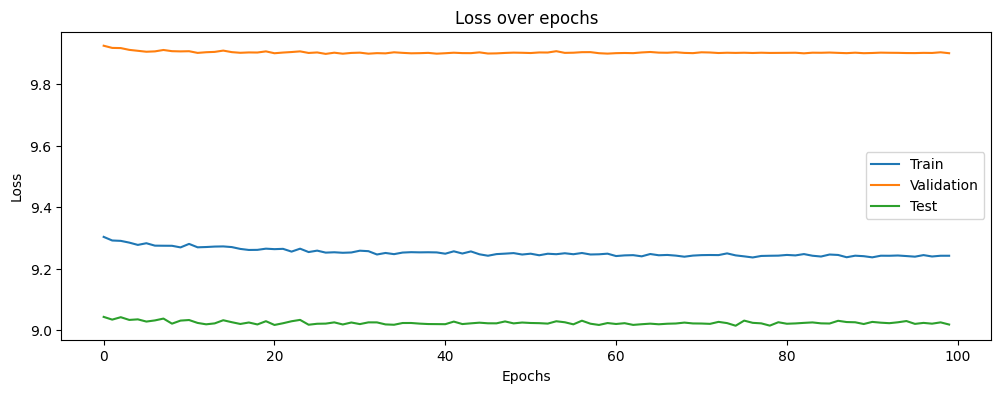

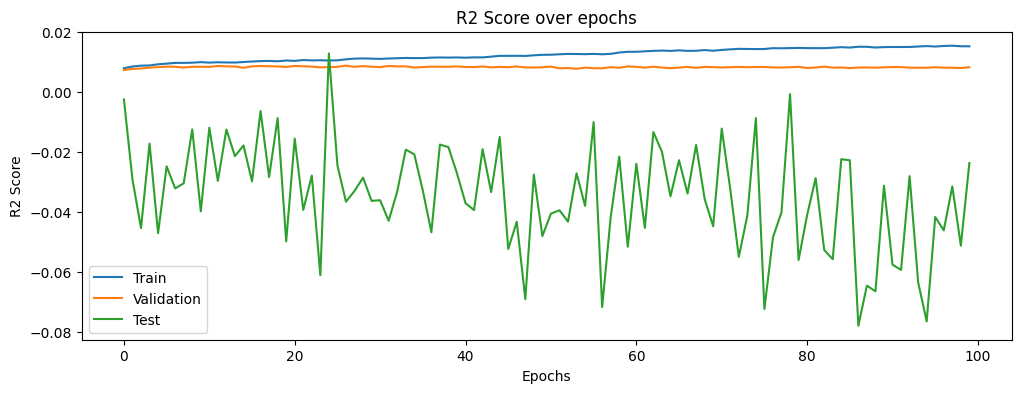

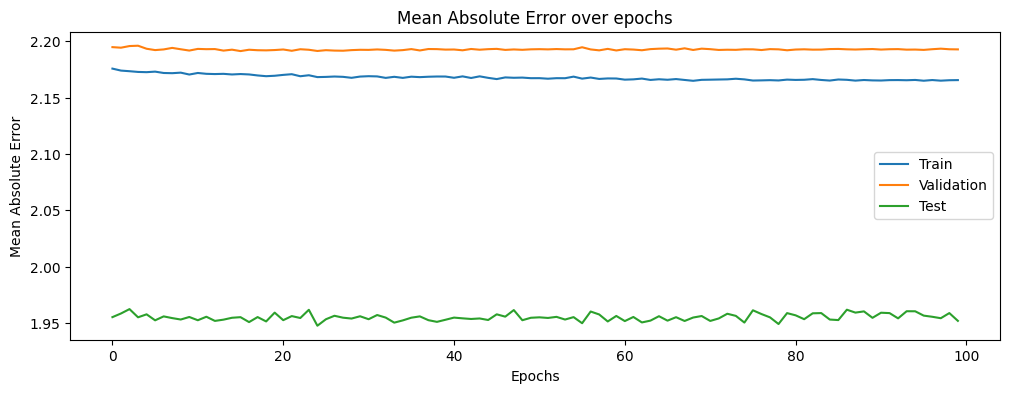

In [513]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot R2 scores
plt.figure(figsize=(12, 4))
plt.plot(train_r2_scores, label='Train')
plt.plot(val_r2_scores, label='Validation')
plt.plot(test_r2_scores, label='Test')
plt.title('R2 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

# Plot MAEs
plt.figure(figsize=(12, 4))
plt.plot(train_maes, label='Train')
plt.plot(val_maes, label='Validation')
plt.plot(test_maes, label='Test')
plt.title('Mean Absolute Error over epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Task 3

# Data Handling and Preprocessing

In [754]:
# Specify the paths to your train and test data folders
data_folder_train = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train'
data_folder_test = '/Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test'

# Define the batch size
batch_size = 50

# Create data loaders for train and validation sets (only if the folder contains "train")
dataloader_train, dataloader_val, data_list = create_dataloader_task2(data_folder_train, task='task 3', shuffle=True, batch_size=batch_size)

# Create a separate data loader for the test set
dataloader_test, data_list_test = create_dataloader_task2(data_folder_test, task='task 3', shuffle=False, batch_size=batch_size)

Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/train: 900
Number of training samples: 720
Number of validation samples: 180
Number of data samples in /Users/sambhavjain/Library/Mobile Documents/com~apple~CloudDocs/TU Eindhoven/Q4/Deep Learning/tue-deeplearning/assignments/assignment_2/data/task 2_3/test: 100


# Model Implementation

In [755]:
from torch_geometric.data import batch
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.nn import Linear
import torch.nn.functional as F

class GraphVAE(torch.nn.Module):
    def __init__(self):
        super(GraphVAE, self).__init__()

        # Encoder layers
        self.conv1 = SAGEConv(5, 64)
        self.conv2 = SAGEConv(64, 128)
        self.conv3 = SAGEConv(128, 256)
        self.fc_mu = Linear(256, 20)  # mu layer
        self.fc_var = Linear(256, 20)  # logvariance layer

        # Decoder layers
        self.fc1 = Linear(20, 256)
        self.conv4 = SAGEConv(256, 128)
        self.conv5 = SAGEConv(128, 64)
        self.conv6 = SAGEConv(64, 5)

    def encode(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var


    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, edge_index):
        x = F.relu(self.fc1(z))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = self.conv6(x, edge_index)
        return x

    def forward(self, data):
        mu, log_var = self.encode(data.x, data.edge_index, data.batch)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, data.edge_index), mu, log_var



# Model Training

In [756]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
print(f'Loaded device: {device}')

Loaded device: cpu


In [757]:
def loss_func(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kld

In [758]:
model = GraphVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(loader):
    model.train()
    total_loss = 0
    total_samples = 0

    for data in loader:
        data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_func(recon_batch, data.x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        total_samples += data.num_graphs

    return total_loss / total_samples

def evaluate(loader):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_func(recon_batch, data.x, mu, logvar)
            total_loss += loss.item() * data.num_graphs
            total_samples += data.num_graphs

    return total_loss / total_samples


In [759]:
epochs = 10
start = time.time()

train_losses = []
val_losses = []
test_losses = []

for epoch in tqdm(range(1, epochs + 1)):

    train_loss = train(dataloader_train)
    val_loss = evaluate(dataloader_val)
    test_loss = evaluate(dataloader_test)

    toc = time.time()
    print(f'EPOCH: {epoch:03d}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TEST LOSS: {test_loss:.4f}. TRAINING TIME SO FAR: {toc - start:.1f} s\n')

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/sambhavjain/miniforge3/envs/deeplearning/lib/python3.11/site-packages/torch_geometric/nn/conv/message_passing.py", line 272, in _lift
    return src.index_select(self.node_dim, index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
IndexError: index out of range in self

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/sambhavjain/miniforge3/envs/deeplearning/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/px/5wjhblnd0kg9vy8wzhfd1dmm0000gn/T/ipykernel_30574/453480863.py", line 10, in <module>
    train_loss = train(dataloader_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/px/5wjhblnd0kg9vy8wzhfd1dmm0000gn/T/ipykernel_30574/3941628764.py", line 12, in train
    recon_batch, mu, logvar = model(data)
                              ^^^^